# A Simple "Bit Adder" Quantum Circuit

Our goal here is to create a quantum circuit that's capable of performing binary addition. In other words, we want to be able to add: <br>
1 + 0 = 1 <br>
0 + 1 = 1 <br>
1 + 1 = 2 == 10 (binary) <br>
<br>
We'll start by creating some basic quantum circuits to get the hang of working with Qiskit and then work our way up to a functional quantum bit adder (aka- a "half adder" circuit).

In [85]:
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram

Here we'll define the number of qubis to use in a quantum circuit and the number of classical bits to store the measurement of the qubits.

In [86]:
n = 8
n_q = n # number of qubits in the circuit
n_b = n # numnber of classical output bits to hold extracted measurements
qc_output = QuantumCircuit(n_q,n_b)

Add a measure operation to each of our qubits.

In [87]:
for i in range(n):
    qc_output.measure(i, i)

Draw the quantum circuit.

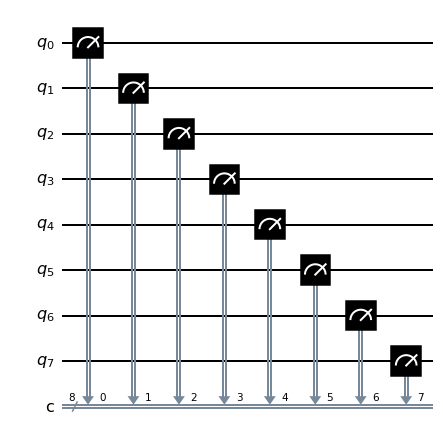

In [88]:
qc_output.draw()

Since the qubits are initialized to zero by default, without doing any operations to them, performing a measurement on them will also yield zero. If we run the circuit and plot the results in a histogram, we'll find that the results are 00000000 (0 for each qubit).

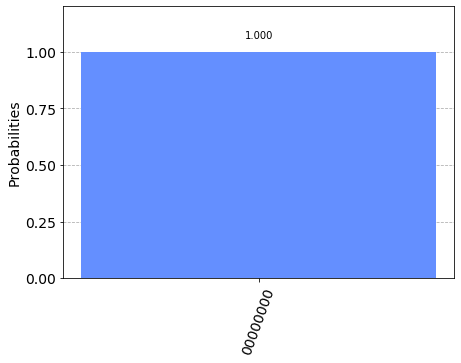

In [89]:
q_counts = execute(qc_output, Aer.get_backend('qasm_simulator')).result().get_counts()
plot_histogram(q_counts)

Now let's encode the inputs of our circuit.  We'll start by implementing an X gate (known as a NOT or a bit flip operation --> 0 becomes 1 and 1 becomes 0)

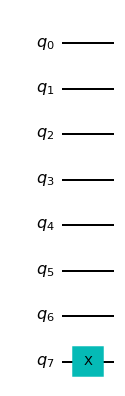

In [90]:
qc_encode = QuantumCircuit(n)
qc_encode.x(7) # since our start index is 0, the 8th qubit corresponds to index 7
qc_encode.draw()

Now let's combine the qc_encode and qc_output circuits together and draw the resulting circuit.

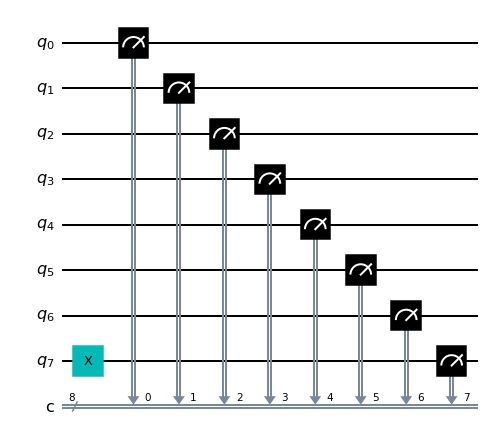

In [91]:
qc = qc_encode + qc_output
qc.draw()

Run the combined circuit and view the results in a histogram again.

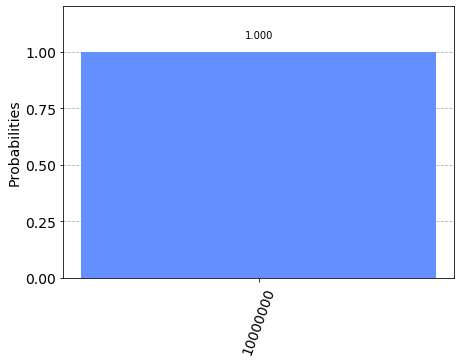

In [92]:
q_counts_combined = execute(qc, Aer.get_backend('qasm_simulator')).result().get_counts()
plot_histogram(q_counts_combined)

Notice our output is now 10000000 instead of 00000000 like it previously was because we flipped the 8th qubit's value from 0 to 1.

Now, we're starting to get to the fun part... adding two bit values together (binary addition, known as a half adder).
Our half adder needs to perform the following:<br>
&emsp; <b>0+0 = 00 <br>
&emsp; 0+1 = 01 <br>
&emsp; 1+0 = 01 <br>
&emsp; 1+1 = 10 </b>

The rightmost bit is determined by whether the two bits being added are different or the same.  Since 0+0 and 1+1 are the same, the rightmost bit is 0.  But since 1+0 and 0+1 are different, the rightmost bit is 1. <br><br>
We can visualize this using a truth table for a classical bit's XOR gate.

| Input 1 | Input 2 | XOR Output |
| --- | --- | --- |
| 0 | 0 | 0 |
| 0 | 1 | 1 |
| 1 | 0 | 1 |
| 1 | 1 | 0 |

A quantum computer does this logic check operation using the a controlled-NOT gate (CNOT). 

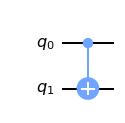

In [93]:
n_bits_to_add = 2
qc_cnot = QuantumCircuit(n_bits_to_add)
qc_cnot.cx(0,1)
qc_cnot.draw()

The CNOT gate is applied to a pair of qubits, where q0 is the <i>control</i> qubit, and q1 is the <i>target</i> qubit.  The CNOT gate flips the <i>target</i> qubit if and only if the <i>control</i> qubit is 1.

Note: in Qiskit, qubits are ordered from right to left, meaning if we have 3 qubits, their order would be q2,q1,q0. <br> So, if each qubit was in the following state:<br>
q0 = 0 <br>
q1 = 1 <br>
q2 = 1 <br>
then we'd represent them as: 110

Let's create a simple CNOT gate between two qubits to see what happens...

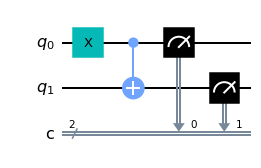

In [94]:
qc = QuantumCircuit(2,2) # 2 qubits and 2 classical bits
qc.x(0) # flip q0 from 0 to 1
qc.cx(0,1) # CNOT gate
qc.measure(0,0) # measure the first qubit, put result in the first classical bit
qc.measure(1,1)
qc.draw()

Note: in the circuit drawing above, double line at the bottom with a "C" to the left represents the "classical bit register".  The "2" next to the "C" means the register contains a total of two classical bits. The first measurement gate with an arrow pointing to the zero, means q0's measurement result is going in classical bit zero, and q1's measurement result is going in classical bit 1.

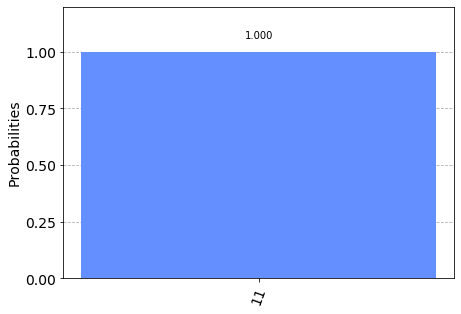

In [95]:
result = execute(qc, Aer.get_backend('qasm_simulator')).result().get_counts()
plot_histogram(result)

When we execute the circut above, we get 11 as the output.  This is because CNOT sees that the input values are different (q0=1, q1=0), and since q0 (our control qubit) is one, it applies NOT (flips the value) to q1 (our target qubit), changing it from zero to one. Thus, our state goes from 01 to 11.  We can visualize this with the table below.

| Input (q1 q0) <br> (target, control) | Output (q1 q0) <br> (target, control)|
| ----- | ----- |
| 00 | 00 |
| 01 | 11 |
| 10 | 10 |
| 11 | 01 |

To perform addition using our half adder, we don't want to overwrite the state of our input qubits, so instead we'll write the result to a different pair of qubit.  To do this we'll use two CNOT gates (remember, CNOT overwrites the target qubit, so that's why we are using new qubits!).<br>

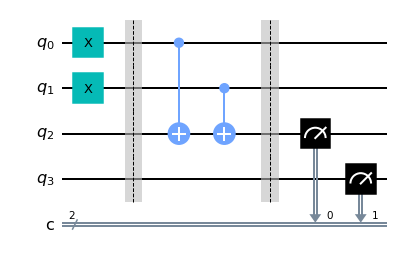

In [96]:
qc_half_adder = QuantumCircuit(4, 2)
# Encode the inputs in q0 and q1
qc_half_adder.x(0) # set q0=1
qc_half_adder.x(1) # set q1=1
qc_half_adder.barrier()
# Apply the CNOT gate on input qubits and write result to q2
qc_half_adder.cx(0,2)
qc_half_adder.cx(1,2)
qc_half_adder.barrier()
# Extract the outputs and write to classical bits 0 and 1
qc_half_adder.measure(2,0)
qc_half_adder.measure(3,1)

qc_half_adder.draw()

Note: the barrier() method basically tells the transpiler not to combine any of the circuit from before and after the barrier together during its optimization of the circuit. This mainly comes into play when doing certain sequential gate operations to a qubit and each step needs to be executed as is, and not combined into a single "more optimized" step (if possible). <br>It's like saying, "Add 3 + 5, and show me the result, then add 4 to that and show me the result", when we know that's the same thing as saying "Add 3 + 5 + 4 and show me the result".  Mathematically, the end result is the same, but you may actually want to see the result of "3 + 5" before deciding if you want to do anything further.

So with the circuit above, we've covered the following two cases (remember, q2 is initialized to zero!): <br>
(q0=0, q2=0)  00 -> 00 ==> 0 + 0 = 0 <br>
(q0=1, q2=0)  10 -> 10 ==> 1 + 0 = 1 <br>
(q1=0, q2=0)  00 -> 00 ==> 0 + 0 = 0 <br>
(q1=1, q2=0)  10 -> 10 ==> 1 + 0 = 1 <br>

(looking back at our truth table...)

| Input | Output |
| ----- | ----- |
| 00 | 00 |
| 10 | 10 |

Yay!! We can successfully add 0 and 1! <br>
But what about the case of 01 -> 11 from our CNOT truth table? Well, we don't actually want this case because we know that 0 + 1 = 1, which is the same as 1 + 0 = 1.  <br>
<br>
So we're left with the last case: 1 + 1 = 2 == 10 (2 in binary).  To do this, we'll look at the values of q0 and q1 and if (and only if) they are they are both 1, we'll do a NOT gate on q3 (flip it from 0 to 1). <br>
This will require a new gate, since CNOT only has one control and one target qubit -- we need 2 control qubits and 1 target qubit.  This new gate is called the <i>Toffoli</i> gate.  It's basically an AND gate. So let's update our circuit to include this new gate -- the "Controlled-Controlled-NOT" gate (ccx).

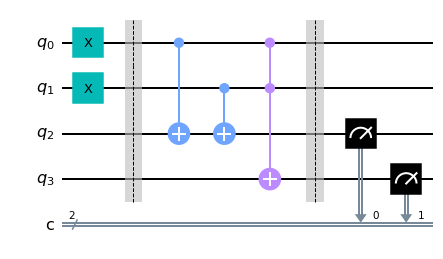

In [97]:
qc_half_adder = QuantumCircuit(4, 2)
# Encode the inputs in q0 and q1
qc_half_adder.x(0) # set q0=1
qc_half_adder.x(1) # set q1=1
qc_half_adder.barrier()
# Apply the CNOT gate on input qubits and write result to q2
qc_half_adder.cx(0,2)
qc_half_adder.cx(1,2)
qc_half_adder.ccx(0,1,3)
qc_half_adder.barrier()
# Extract the outputs and write to classical bits 0 and 1
qc_half_adder.measure(2,0)
qc_half_adder.measure(3,1)

qc_half_adder.draw()

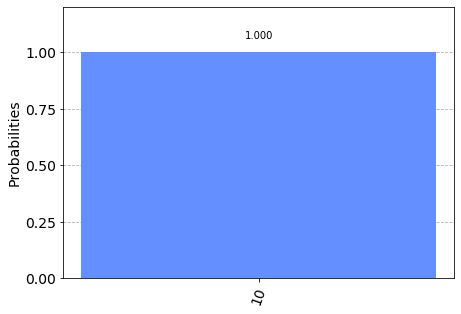

In [98]:
counts_1_plus_1 = execute(qc_half_adder, Aer.get_backend('qasm_simulator')).result().get_counts()
plot_histogram(counts_1_plus_1)

And there we have it -- when q0=1 and q1=1, we've calculated 1 + 1 = 10 (2 in binary)!

We can make this a little prettier and write our half adder quantum circuit as a function so we can test different values.

In [99]:
def half_adder(q0, q1):
    qc_half_adder = QuantumCircuit(4, 2) # all qubits initialized to zero
    # Encode the inputs in q0 and q1
    if q0 == 1:
        qc_half_adder.x(0) # set q0=1
    if q1 == 1:
        qc_half_adder.x(1) # set q1=1
    qc_half_adder.barrier()
    
    # Apply the CNOT gate on input qubits and write result to q2
    qc_half_adder.cx(0,2)
    qc_half_adder.cx(1,2)
    qc_half_adder.ccx(0,1,3)
    qc_half_adder.barrier()
    
    # Extract the outputs and write to classical bits 0 and 1
    qc_half_adder.measure(2,0)
    qc_half_adder.measure(3,1)

    
    
    counts = execute(qc_half_adder, Aer.get_backend('qasm_simulator')).result().get_counts()
    return plot_histogram(counts)

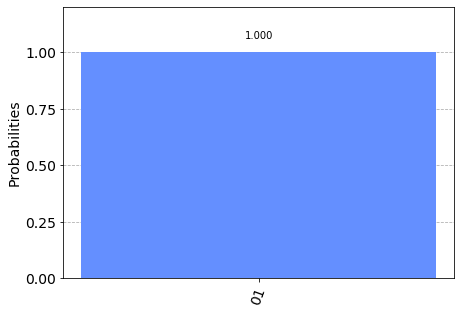

In [100]:
half_adder(1, 0)